# Origin Destination Dataset

This notebook presents an analysis of the origin destination datasets provided by the Sao Paulo government. The datasets contain information about how people move through the city in a tipycal workday, whether to go for work, school or to chill. Also, there are some socio-economic data regarding family income, gender, age and other information that we use to analyze the behaviour of people's trajectories.

## Datasets

We will be using the datasets from the Origin Destination census from 2017.

## Variables of Interest

The dataset contain dozens of variables, we focus our analysis in a small group to gather insights from the behaviour of the population. Here we give a brief description of those. Furthermore we start with a simple analysis on each one until we get to deeper insights about how people move in a typical day of the week.

 - **ZONA_O**: The origin;
 - **ZONA_D**: The destination zone;
 - **MODO_PRIN**: Main transport mode used in the trip;
 - **COORD_X_ORIGIN**: Latitude in the origin;
 - **COORD_Y_ORIGIN**: Longitude in the origin;
 - **COORD_X_DESTINATION**: Latitude in the destination;
 - **COORD_Y_DESTINATION**: Longitude in the destination;
 - **FEVIAG**: Expansion factor of the trajectory that represents how many more trips like that may exist.
 - **CD_ENTRE/ID_VIAG**: Binary flag to register if the interviewed person declared a trip. We want discard registers without trips.
 
 
## Spatial aggregation of the data

Data aggregation is a common technique to reduce the amount of information to be processed or visualized.
When we talk about georeferenced movement data in a city we can aggregate trips from point based locations to region based locations to work with the spatial properties in a higher order of scale.
This kind of aggregation is thus limited to the granularity of the collected data. In our case, the dataset from the 2017 record specific locations that maps to neighborhood levels. This allow us to summarize this information from neighborhood scale to other levels, for example, the district scale division.

The image below is from the census made in 1987. The city were divided into 16 different regions and the information was aggregated to display the amount of flows between them. In that year, the collected information of the census had the granularity of 416 regions, but the design of this visualization would not fit to such number of elements. 

<div>
  <div>
    <h3>Flows between regions in 1987<h3>
    <img src="../images/od87/abstract-regions-flow.jpg">
  </div>
</div>

For someone intended to understand the overall structure of trajectories in a city, it is interesting to have the possibility of seeing the information in different scale perspectives. Given this situation we explore the use of bundling in different levels of spatial aggregation and how they affect the intrinsec information of the data. However, from the bundling perspective, specially the kernel density model that we use, this spatial aggregation can be manipulated by two main factors: The granularity of the input data and the variation of the kernel size parameter. So we design the following experiments to answer questions like "How can we see the structure of our dataset in different scales?" or "What are the advantages or disadvantages of seing the data in different scales?" and "What scale choices better show the connection between regions in the city?" 

### Experiments:

As we said before, the spatial properties and spatial aggregations that we can generate with CUBu depends on a few things. First, the granularity of the data that maps longitudes and latitudes of the trajectories. Secondly, some parameters in the algorithm controls the level of details in the resulting visualization. We then present alternatives of spatial aggregations that can have a significant impact in the bundled visualization, which we present below:

 - **Variations in the data granularity:** How different is the bundled visualization when using region centroids and specific location as point coordinates? How this different levels of spatial scales impact the overall structure of the visualization?
 
 - **Variations in the kernel size:** How different is the bundled visualization when using big kernels and small kernels? Can we achieve a multi-scale visualization based on different kernel sizes? 
 
## References for the CUBu Framework

Cubu is a framework for bundling graphs. We use it to create our bundled visualizations of our dataset. For more information, check this article from the authors of CUBu.

https://ieeexplore.ieee.org/abstract/document/7374742

In [82]:
# General Imports
import sys
import geopandas as gpd #pip install geopandas descartes
import pandas as pd #pip install pandas
import matplotlib.pyplot as plt # pip install matplotlib
import numpy as np
from pyproj import Proj, transform

from multiprocessing import Pool
from dbfread import DBF #pip install dbfread
from simpledbf import Dbf5 #pip install simpledbf

# Local imports
sys.path.append('/home/peach/ic')
import scripts.utils as utils

# Loading the dataset

First we load the data from the 2017 dataset.

In [83]:
# Read the spec file from 2017
YEAR = 2007
DATASETS_DIR = '../data/walks-by-zone/'
MY_DATASET = 'walks-by-zone-1.csv'

trips = pd.read_csv(f'{DATASETS_DIR}{MY_DATASET}')

# Number of entries in the datasets

The OD census covers only a fraction of the population. Some statistical factors are used to extrapolate the numbers to the entire city. We first count the number of entries to have an idea of the nature of our datasets.


Number of entries in %s dataset: %s 2007 99


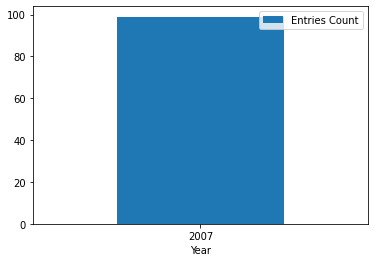

In [84]:
trips_count = len(trips)

df = pd.DataFrame({'Year': [YEAR], 'Entries Count': [trips_count]})
df.plot.bar(x='Year', y='Entries Count', rot=0)
print("Number of entries in %s dataset: %s", YEAR, trips_count)

# Attribute `FE_VIA`: preparing to compute total number of trips

Some statistical factors are used to extrapolate the numbers to the entire city. The `FE_VIA` (expansion factor of trips) is one of them and tell us how many similar trips exist given a record. If we simply sum the factor of all records we have the total number of trips in the city estimated by the census.

In [85]:
# Check if all datasets contains the column 'FE_VIA'
CHECK_ORIGIN_ATTRIBUTE = [x.__contains__('FE_VIA') for x in [trips.columns]]

if not(trips.columns.__contains__('FE_VIA')):
    raise Exception("Error, the dataset does not uses FE_VIA as attribute name.")

# Check missing data in FE_VIA attribute
print("There is missing data 'FE_VIA' attribute?:", not(all(trips[['FE_VIA']].notna().values)))


There is missing data 'FE_VIA' attribute?: False


# Understanding missing `FE_VIA` and incomplete entries

As mentioned by the METRO-SP, the records in the datasets contain a flag that tells if the entry is complete or not. By means: **A complete entry is considered to have a trajectory associated to the interviewed family, meaning that they move throughouth the city regularly**. This can lead to missing data in `FE_VIA` attribute, as there is no sense to record an expansion factor for incomplete entries that does not have a trajectory associated. We can simply remove those entries from the dataset. 

**PS:** Albeit other sources of inconsistency in the data can lead to missing values in `FE_VIA` attribute, but as they are only a small part, we ignore them.

Number of incomplete entries in the dataset: 0


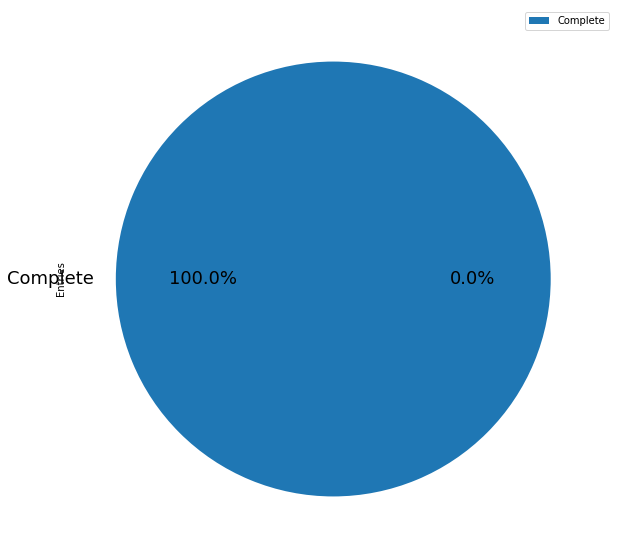

In [86]:
# Count the number of NaN values in FE_VIA attribute
incomplete_trips = trips[trips['FE_VIA'].isna()]

# Create a dataframe containing the number of complete and incomplete entries for each year
df = pd.DataFrame({'Entries': [trips_count-len(incomplete_trips), len(incomplete_trips)]},
                    index=['Complete', 'Incomplete'])

df.plot.pie(subplots=True, autopct='%1.1f%%', figsize=(15,10), explode=(0.04,0), fontsize=18)
print("Number of incomplete entries in the dataset:", len(incomplete_trips))

# Remove missing data according to FE_VIA attribute
trips.dropna(subset=['FE_VIA'], inplace=True)

# Computing the total number of trips

After removing incomplete trips we can use the factor of expansion `FE_VIA` to compute the total number of trips in the city in a regular day. We simply sum this attribute for all given entries.

Total of 3135 million trips in the dataset


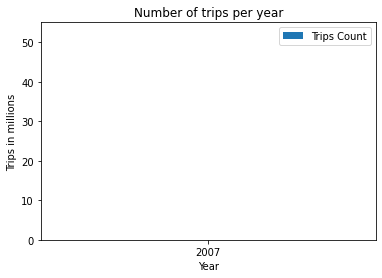

In [87]:
expanded_trips_count = trips[['FE_VIA']].sum()[0]

base_count = expanded_trips_count/1000000

df = pd.DataFrame({'Year': [YEAR], 'Trips Count': [expanded_trips_count/1000000]})
ax = df.plot.bar(x='Year', y='Trips Count', rot=0)
ax.set_ylim(top=55)
ax.set_ylabel("Trips in millions")
plt.title("Number of trips per year")

# Add this loop to add the annotations
for p in ax.patches[1:]:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format((height/base_count) - 1) + ' increase', (x, y + height + 1.1))

print("Total of %i million trips in the dataset" % expanded_trips_count)

# Rounding expansion factor `FE_VIA`

This variable is a float number, which signs we can have 1.5 trip multiplication factor with decimal component. This can be a problem when calculating average values for some variables, i.e. `duration`. Imagine if we have 1.5 trips with duration 30 minutes. Does that mean that we have 1 trip that last 30 minutes and another one that last 15 minutes? Again, imagine if we want to scale the number of records in the dataset accordinly, how can we make a 1.5 duplication of an entry?

To solve this we can cast this value to int. The problem is that we will be losing some data, but thinking in absolute values, this lost is not so significant for our dataset. In the worst case, where all entries have factors containing `.999999` in the decimal part (i.eg. `230.9, 100.9`), we lose at most N entries from the total sum when using the expansion factor, as we will end with `230` and `100`. Thinking in absolute values this will not be a big lost as the total sum of trips is in the order of millions `10^6`, and number of entries that we use to calculate the total number of trips is one order of magnitude below, thousands `10^5`.

- Dataset:
      	Expanded Trips (float): 3135
      	Rounded Trips (int): 3098
      	Lost trips: 37, 1.184209%


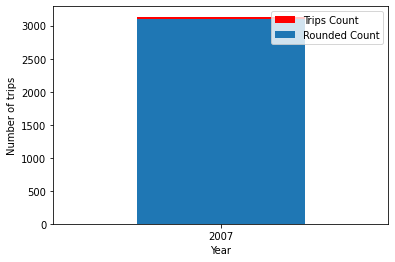

In [88]:
# Calculate the number of trips rounding the factor of expansion to a floor value
rounded_expanded_trips_count = trips[['FE_VIA']].astype(int).sum()[0]

# Calculate the percentual of trips removed when cliping the factor of expansion
percentual = 100*(expanded_trips_count - rounded_expanded_trips_count)/expanded_trips_count

df = pd.DataFrame({'Year': [YEAR],
                   'Trips Count': [expanded_trips_count],
                   'Rounded Count': [rounded_expanded_trips_count]
                  })

fig, ax1 = plt.subplots()
ax1.set_ylabel('Number of trips')

df.plot.bar(x='Year', y='Trips Count', ax=ax1, color='red', rot=0)
df.plot.bar(x='Year', y='Rounded Count', ax=ax1, rot=0)

print("""- Dataset:
      \tExpanded Trips (float): %i
      \tRounded Trips (int): %i
      \tLost trips: %i, %f%%""" % 
      (expanded_trips_count, rounded_expanded_trips_count, expanded_trips_count - rounded_expanded_trips_count, percentual))

# Round FE_VIA to nearest floor integer value
trips['FE_VIA'] = trips[['FE_VIA']].astype(int)

In [89]:
# Check if the datasets contains the column 'ZONA_O' or the already transformed 'ORIGIN_ID'
if not(trips.columns.__contains__('ZONA_O') or trips2.columns.__contains__('ORIGIN_ID')):
    raise Exception("Error, the dataset does not uses ZONA_O or ORIGIN_ID as attribute name.")

# Rename ZONA_O column to ORIGIN_ID
trips.rename(columns={"ZONA_O": "ORIGIN_ID"}, inplace=True)

# Cast ORIGIN_ID to int
trips['ORIGIN_ID'] = trips[['ORIGIN_ID']].astype(int)

## 1.1 Missing ORIGIN_ID data

We can not figure out what are the origins of entries without this data, so we simply drop them from our analysis.

In [90]:
trips.dropna(subset=['ORIGIN_ID'], inplace=True)

## 2. Attribute ZONA_D

Similar to `ZONA_O` the **(2017)** dataset uses `ZONA_D` to convey information about the zone of destination of a given trajectory. We can now see the same data regarding the incoming traffic in the 516 regions of the city to spot the behaviour of citizens.

In [91]:
# Check if the datasets contains the column 'ZONA_O' or the already transformed 'ORIGIN_ID'
if not(trips.columns.__contains__('ZONA_D') or trips.columns.__contains__('DESTINATION_ID')):
    raise Exception("Error, the dataset does not uses ZONA_D or DESTINATION_ID as attribute name.")

# Rename ZONA_O column to ORIGIN_ID
trips.rename(columns={"ZONA_D": "DESTINATION_ID"}, inplace=True)

# Cast ORIGIN_ID to int
trips['DESTINATION_ID'] = trips[['DESTINATION_ID']].astype(int)

## 1.1 Missing DESTINATION_ID data

We can not figure out what are the destination of entries without this data, so we simply drop them from our analysis.

In [92]:
trips.dropna(subset=['DESTINATION_ID'], inplace=True)

## A) Show the variance of  incoming trips in a given year:

Color coding here is relative to the considered year. Thus, we can spot areas with most flows in that given year. If we side-by-side plots from both years, its possible to see if there's any difference in the distribution of outgoing flows across the years.

### Incoming vs Outcoming Trips

If we get the statistics of incoming and outcoming flow in each region, we can perceive the similarity between the mean, max, min and percentile values for both kinds of flows.

## Reducing the dataset

We could see the distribution of incoming and outgoing trips per region in the previous histogram and density maps. This lead to a total of 42 million trips in the entire city. A direct strategy to represent the entire dataset is to duplicate entries according to the expansion factor `FE_VIA` and use as the input file in CUBu. However, this would lead to a huge computational complexity in terms of algorithm calculation and image rendering and given the limit of resources in our research (hardware and time) we need to bypass this complexity. A solution to this is to reduce the dataset.

Given the previous tests, we were able to run about a million edges, so we need to reduce our dataset to this order of magnitude. To achieve about a million edges we would need to divide the 42 million trips by a factor around 30, so we investigate the attribute `FE_VIA`, used to expand the sample data to represent the entire city, to see how can we reduce the total number of trips. The first step is to check the smaller value of `FE_VIA` and divide all values by that number. If this factor is not enough, we need to remove some edges from the dataset and analyse the impact of this removal.

### Counting the number of edges

To reduced the dataset is to take a fraction of it preserving its distribution. A direct approach is to investigate the smaller value of `FE_VIA` and use it as a factor to reduce our dataset dividing all values by that factor. This approach is desirable as it keeps the distribution of the data. To figure what is this number we select all unique edges (pairs of origins and destinations), summing the `FE_VIA` attribute of duplicated edges. Then we describe our dataset to see the behaviour of the `FE_VIA` attribute. The desirable value given our restrictions is 30.

In [93]:
# Count the number of edges (pairs of origins and destinations) and sort by count
trips.groupby(by=['ORIGIN_ID', 'DESTINATION_ID']).sum()[['FE_VIA']].sort_values(by=['FE_VIA', 'ORIGIN_ID', 'DESTINATION_ID']).describe()

,FE_VIA
count,33.000000
mean,93.878788
std,135.236311
min,18.000000
25%,22.000000
50%,43.000000
75%,106.000000
max,748.000000


Our analys showed that the minimum value of `FE_VIA` is 1. This mean that we can not make any reduction based on that, so we need to remove some trips from the dataset to achieve the reduction needed.

### Removing trips with small weights 

The `FE_VIA` acts like a weight of the edges. Previous analyisis showed that this weight ranges from `1 to 238999`, being most of them placed around the mean value of 80k. Considering all the 42 million of trips, we investigate what would happen to the distribution of trips if we remove edges with small weights that correspond to a minor fraction of the datasete. This way we could divide `FE_VIA` by a reasonable value and obtain a reduced dataset suitable for our bundling visualization. For instance, we check the distribution of trips with `FE_VIA` around 30, which would make it possible to achieve a dataset reasonable for our computation. We then analyse the impact of removing trips below a given threshold in the distribution of the trips. Its important to remember that such reduction is needed because of limits in our available resources, and given enough time and hardware, it would be possible to make the entire computation.

So we plot the percentual loss of data in the 42 million trips if we remove trips where the expansion factor `FE_VIA` below 50.

In [94]:
# Count the total number of trips
total_trips = trips[['FE_VIA']].sum()[0]
print("Total expanded trips: ", total_trips)

Total expanded trips:  3098


<AxesSubplot:xlabel='FE_VIA'>

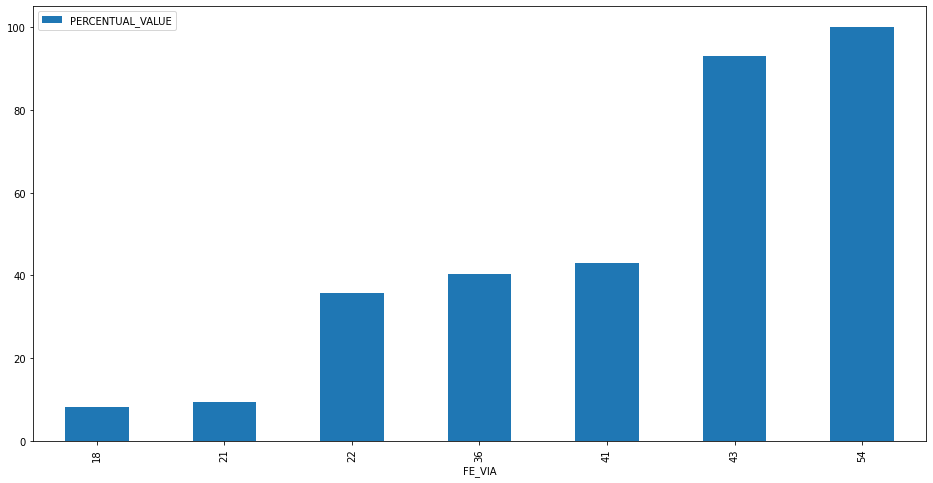

In [95]:
# Sum FE_VIA for all edges (pairs of origins and destinations)
edges_weights = trips.sort_values(by='FE_VIA')
edges_weights[['PERCENTUAL_VALUE']] = edges_weights[['FE_VIA']]*100/total_trips

# Filter by weights less than 60 and plot the accumulated distribution
edges_weights = edges_weights.loc[edges_weights['FE_VIA'] <= 70]#
edges_weights = edges_weights.groupby(by='FE_VIA').sum().reset_index()
edges_weights[['PERCENTUAL_VALUE']] = edges_weights[['PERCENTUAL_VALUE']].cumsum()
edges_weights.plot.bar(x='FE_VIA',y='PERCENTUAL_VALUE', figsize=(16,8))


### Removing trips with FE_VIA below 55

The previous histogram accumulate the number of trips according to the factor of expansion `FE_VIA` and the percentual contribution to the entire dataset of 41 million trips. It show us that if we remove trips with expansion factor below 55 we lose around 2% of the information of the people moving through the city. Removing this trips enable us to divide the number of trips by 55, reducing our sample and preserving its distribution (considering the remaining trips). From that, we can analyse the impact of this removal by comparing the number of incoming and outgoing trips in each region after this reduction process.

So we remove edges where the expansion factor `FE_VIA` is less than 55. After that, we reduce the remaining trips by this factor, dividing `FE_VIA` by 55. For example if an entry has 110 as expansion factor, we would replicate this entry 110 times in our final dataset. Now, after the reduction, we divide 110 by 55 ending with 2 replicas only.

In [96]:
# Setting the reduction factor to 55 we lose only 11% of our dataset
# and we can reduce our data to around 1 million entries instead of 41 million
REDUCTION_FACTOR = 55

reduced_trips = trips.copy().loc[trips['FE_VIA'] >= REDUCTION_FACTOR]
reduced_trips['FE_VIA'] = reduced_trips['FE_VIA'].div(REDUCTION_FACTOR).astype(int)

# Attributes CO_O_X, CO_O_Y, CO_D_X and CO_D_Y

This are the specific locations in the level of neighborhoods contained in the data. We will use this coordinates as our latitude and longitude points. In our analysis we removed points where the ORIGIN_ID and DESTINATION_ID information was missing and now we should do something about the missing coordinate values. But now the strategy is a bit different, if a point misses the coordinates we can replace it by the centroid coordinate of its origin and destination zone (because we know it). So first, we check if this values are missing and if we need to do the replacement.

Also, it is important to remember that this points must be in the same projection system as the shapefile that loads the map within the CUBu Framework. The 2017 dataset brings the data in the `epsg:22523` projection. As we have adopted the projection `ellps:WGS84`, we need to convert the coordinates data in our dataset.

So we proceed with the coordinates attributes in two steps:

- Step 1: Find and replace missing coordinates by centroids coordinates
- Step 2: Change coordinates projection to ellps:WGS84

In [97]:
### Step 1: Find and replace missing coordinates by centroids
if all(reduced_trips[['CO_O_X', 'CO_O_Y', 'CO_D_X', 'CO_D_Y']].notna()):
    print("There is no missing coordinates data, you can proceeed!")

There is no missing coordinates data, you can proceeed!


In [98]:
### Step 2: Change coordinates projection to ellps:WGS84

# Create a dataframe containing origin coordinates CO_O_X and CO_O_Y
geo_trips_origins = gpd.GeoDataFrame(
    reduced_trips[['CO_O_X', 'CO_O_Y']], geometry=gpd.points_from_xy(reduced_trips.CO_O_X, reduced_trips.CO_O_Y))

# Convert origin coordinates to the desired projection 
geo_trips_origins.crs = {'init': 'epsg:22523'}
geo_trips_origins.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'no_defs': True}, inplace=True)

# Create a dataframe containing origin coordinates CO_D_X and CO_D_Y
geo_trips_destinations = gpd.GeoDataFrame(
    reduced_trips[['CO_D_X', 'CO_D_Y']], geometry=gpd.points_from_xy(reduced_trips.CO_D_X, reduced_trips.CO_D_Y))

# Convert destination coordinates to the desired projection
geo_trips_destinations.crs = {'init': 'epsg:22523'}
geo_trips_destinations.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'no_defs': True}, inplace=True)


/home/peach/ic/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/peach/ic/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [99]:
geo_trips_destinations.head()

,CO_D_X,CO_D_Y,geometry
0,333104.0,7394476.0,POINT (-46.63504 -23.55119)
1,333743.0,7394463.0,POINT (-46.62879 -23.55137)
2,333453.0,7394501.0,POINT (-46.63162 -23.55100)
3,333814.0,7394428.0,POINT (-46.62809 -23.55169)
4,333453.0,7394501.0,POINT (-46.63162 -23.55100)


In [100]:
# Replace data by the new transformed coordinates
reduced_trips['CO_O_X'] = geo_trips_origins.apply(lambda x: x['geometry'].x, axis=1)
reduced_trips['CO_O_Y'] = geo_trips_origins.apply(lambda x: x['geometry'].y, axis=1)
reduced_trips['CO_D_X'] = geo_trips_destinations.apply(lambda x: x['geometry'].x, axis=1)
reduced_trips['CO_D_Y'] = geo_trips_destinations.apply(lambda x: x['geometry'].y, axis=1)

### Add time information

Adds departure and arrival times to our trips so we can filter in different times of the day

In [101]:
# Add time information to our trips
reduced_trips['FRACTIONED_MIN_SAIDA']= reduced_trips[['MIN_SAIDA']]/100
reduced_trips['FRACTIONED_MIN_CHEG']= reduced_trips[['MIN_CHEG']]/100
reduced_trips['DEPARTURE_TIME']= reduced_trips[['H_SAIDA', 'FRACTIONED_MIN_SAIDA']].sum(axis=1)
reduced_trips['ARRIVAL_TIME']= reduced_trips[['H_CHEG', 'FRACTIONED_MIN_CHEG']].sum(axis=1)   

reduced_trips[['ARRIVAL_TIME', 'DEPARTURE_TIME', 'H_SAIDA', 'H_CHEG', 'MIN_SAIDA', 'MIN_CHEG']].describe()

,ARRIVAL_TIME,DEPARTURE_TIME,H_SAIDA,H_CHEG,MIN_SAIDA,MIN_CHEG
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,12.808990,12.641414,12.474747,12.606061,16.666667,20.292929
std,3.998844,4.024980,4.051564,3.984199,18.419710,17.049898
min,3.100000,3.000000,3.000000,3.000000,0.000000,0.000000
25%,9.275000,9.000000,9.000000,9.000000,0.000000,5.000000
50%,12.500000,12.450000,12.000000,12.000000,10.000000,15.000000
75%,15.020000,15.000000,15.000000,15.000000,30.000000,40.000000
max,23.550000,23.500000,23.000000,23.000000,55.000000,55.000000


###  Replicating trips

Our reduced dataset contain the trips that we will work with. The next step is to replicate the entries according to the expansion factor given by the reduced attribute `FE_VIA`. Our strategy to create the input to CUBu is to replicate edges the number of times represented by this attribute.

In [102]:
reduced_trips['FE_VIA_ARRAY'] = reduced_trips.apply(lambda entry: np.arange(entry['FE_VIA']), axis=1)
expanded_trips = reduced_trips.explode('FE_VIA_ARRAY')

In [103]:
print("Reduced dataset contains ", len(reduced_trips), " entries.")
print("Expanded dataset contains: ", len(expanded_trips), " entries")

Reduced dataset contains  99  entries.
Expanded dataset contains:  3098  entries


## Final dataset

The final dataset contain 685.115  entries. Now we can go for our graph visualization and using CUBu framework to explore the spatial properties of trips in the metropolitan area of Sao Paulo.

# Line based visualization and bundling

Now that we took an overview of the flows in each region, the distribution and outlier values, we can go for our line based visualization. The goal of this visualization is to enlighten the connection between regions and show their strength of such flows, based on the density of trips between pairs of regions. So we experiment with different possibilities of spatial aggregations to obtain a multi-scale perspective of the data as follows:

## Experiments

Our experiments cover two main aspects of spatial properties that affects the result of the bundled visualization. Variations in the data granularity and variations in the kernel size parameter. Both aspects are directly associated to the scale of the visualization, so we address as follows:

###  **Variations in the data granularity:**
 - a) Bundle data using region centroids and default kernel size
 - b) Bundle data using point based locations and default kernel size
 - c) Bundle data using macro region centroids and default kernel size
  
This set of experiments allow us to compare how different is the bundled visualization when using region centroids and specific location as point coordinates. For instance, we analyze how this different levels of spatial scales impact the overall structure of the visualization. One important thing to remember is that transport modes has different natures, people that go by foot or by bike usually perform low distances and this can affect the final results if we aggregate those modals by region centroids. This experiments will help us to show this differences.

###  **Variations in the kernel size:**
 - d) Bundle data using point based locations and bigger kernel size 
 - e) Bundle data using point based locations and smaller kernel size
 
The kernel size control the level of aggregation during the bundling iterations. It is the horizon of how far a point see other points. Smaller kernels results in more detailed bundles, with less aggregation of edges. A kernel so small as the point size itself result in a image that looks like no bundling were applied at all. Bigger kernels results in larger areas of aggregation, and thus, less details in the resulting image. This difference acts as a multi-scale parameter, similar to a zoom effect in the image. This experiments help us to understand the impact of the kernel size in the bundling of point based locations. The use of point based locations is a good fit to this experiments as it is the highest level of details of our dataset, so we can play with a wide range of values for the kernel size that goes from no bundling at all (smallest kernel size possible) to a strong bundling (highest kernel size possible).

## b) Bundle data using point based locations and default kernel size

To analyse our data using point latitudes and longitudes, we just select `COORD_X` and `COORD_Y` for origin and destination in our dataset.

 - Step B1: Transform the trips dataset to CUBu format
 - Step B2: Generate the bundled visualizations
 
We use the default kernel size of 15 pixels and the default image resolution of 512x512 pixels.

### Step B1 -  Transform the trips dataset to CUBu format

Now our trips data contain the origins and destinations for each region, we can save it to Cubu format,
specifying the fields as expected by the CUBu framework.

`
cubu_fields = {
    'LON_O': 'CO_O_Y',
    'LAT_O': 'CO_O_X',
    'LON_D': 'CO_D_Y',
    'LAT_D': 'CO_D_X'
}
`

In [104]:
cubu_fields = {
    'DEPARTURE_TIME': 'DEPARTURE_TIME',
    'ARRIVAL_TIME': 'ARRIVAL_TIME',
    'LON_O': 'CO_O_X',
    'LAT_O': 'CO_O_Y',
    'LON_D': 'CO_D_X',
    'LAT_D': 'CO_D_Y',
    'MODOPRIN': 'MODOPRIN'
}

results_dir = DATASETS_DIR + 'processed'

import os
try:
    os.mkdir(results_dir)
except FileExistsError:
    pass

file_path = results_dir + '/' + MY_DATASET
utils.parse_to_cubu(expanded_trips.copy(), file_path, cubu_fields)


File written to  ../data/walks-by-zone/processed/walks-by-zone-1.csv
Cubu colunms:  ['IDX', 'MODOPRIN', 'DEPARTURE_TIME', 'ARRIVAL_TIME', 'LON_O', 'LAT_O', 'LON_D', 'LAT_D']
